# GAN Training Notebook

This notebook shows an example of how the GANs were trained.

To run, one must download the 'models' file that contains all the GAN model classes.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#download data
downloaded = drive.CreateFile({'id':'1VuZGdAGxGDwQT10sg9z4sPvlFk0Xmupq'}) 
downloaded.GetContentFile('sim_av_tumour.csv')  
df = pd.read_csv('sim_av_tumour.csv',dtype=str)

In [0]:
from google.colab import files
files.upload()

In [0]:
from models import cGenerator, Generator, Discriminator, MultiCategorical, CategoricalActivation

import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import time
import pickle

In [0]:
#set the drive to save outputs
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

### Prepare the Data

- set the seed, split the data
- switch first two columns for training data
- one hot encode the training data, inspect variable sizes

In [0]:
#All variables:
pd.DataFrame({'column': df.columns, 'class size': [len(df[column].unique()) for column in df.columns]})

IF NORMAL:

In [8]:
np.random.seed(123)
test_df = df.drop(['TUMOURID', 'PATIENTID', 'DIAGNOSISDATEBEST', 'LINKNUMBER', 'DATE_FIRST_SURGERY'], axis=1).iloc[np.random.permutation(len(df))].iloc[:round(len(df)*0.2)]
test_df[test_df.isna()]= "NA"
X_train, X_test = train_test_split(test_df, test_size=0.1, random_state=42)

ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train)
ohe_df = ohe.transform(X_train)

variable_sizes = [len(X_train[column].unique()) for column in X_train.columns]
print(variable_sizes)
print(np.sum(variable_sizes))

[526, 116, 405, 9, 40, 18, 8, 35, 8, 6, 100, 2, 8, 33, 7, 10, 7, 10, 6, 7, 11, 13, 9, 6, 6, 4, 8, 7, 5]
1430


IF CONDITIONAL:

In [11]:
np.random.seed(123)
test_df = df.drop(['TUMOURID', 'PATIENTID', 'DIAGNOSISDATEBEST', 'LINKNUMBER', 'DATE_FIRST_SURGERY'], axis=1) \
            .iloc[np.random.permutation(len(df))].iloc[:round(len(df)*0.2)]
test_df[test_df.isna()]= "NA"
X_train, X_test = train_test_split(test_df, test_size=0.1, random_state=42)

cols = list(X_train)
cols[1], cols[0] = cols[0], cols[1]
X_train = X_train[cols]

cols = list(X_test)
cols[1], cols[0] = cols[0], cols[1]
X_test = X_test[cols]

ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train)
ohe_df = ohe.transform(X_train)

variable_sizes = [len(X_train[column].unique()) for column in X_train.columns]
print(variable_sizes)
print(np.sum(variable_sizes))

[116, 526, 405, 9, 40, 18, 8, 35, 8, 6, 100, 2, 8, 33, 7, 10, 7, 10, 6, 7, 11, 13, 9, 6, 6, 4, 8, 7, 5]
1430


### Define Training Functions

In [0]:
def plot_loss_grads(d_loss_list, accuracy_list, g_loss_list, d_grad_list, g_grad_list):
    """
    Plot the losses and gradients seen in training of a GAN over time.
    Parameters
    ----------
    d_loss_list : list of discriminator losses
    accuracy_list : list of discriminator accuracies
    g_loss_list : list of generator losses
    d_grad_list : list of discriminator gradients
    g_grad_list : list of generator gradients

    Returns
    -------
    Plots two plots across time: 
    The first shows discriminator and generator losses and discriminator accuracy.
    The first shows discriminator and generator gradients.
    """
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    ax[0].plot(d_loss_list, label="D")
    ax[0].plot(g_loss_list, label="G")
    ax[0].plot(accuracy_list, label="D Accuracy")
    ax[0].legend(loc="upper right")
    ax[0].title.set_text("Loss")

    ax[1].plot(d_grad_list, label="D")
    ax[1].plot(g_grad_list, label="G")
    ax[1].legend(loc="upper right")
    ax[1].title.set_text("Gradients")


def get_losses(mode):
    """
    Define the loss functions depending on the type of GAN.
    Parameters
    ----------
    mode : If mode is 'vanilla', returns the generator and discriminator loss functions for a vanilla GAN
           If mode is 'wgan', returns the generator and discriminator loss functions for a WGAN
    Returns
    -------
    Generator and discriminator loss functions
    """
    if mode == 'vanilla':
        bce = tf.keras.losses.BinaryCrossentropy()

        def g_loss(f_logit):
            f_loss = bce(tf.ones_like(f_logit), f_logit)
            return f_loss

        def d_loss(r_logit, f_logit):
            r_loss = bce(tf.ones_like(r_logit), r_logit)
            f_loss = bce(tf.zeros_like(f_logit), f_logit)
            return f_loss, r_loss

        return d_loss, g_loss, bce

    if mode == 'wgan':
        def g_loss(output_f):
            return - tf.reduce_mean(output_f)

        def d_loss(output_r, output_f):
            f_loss = tf.reduce_mean(output_f)
            r_loss = - tf.reduce_mean(output_r)
            return f_loss, r_loss

        return d_loss, g_loss, None


def gradient_penalty(x_fake, x_real, mode):
    """
    Returns the gradient penalty, for a given batch during training of a GAN.
    Parameters
    ----------
    x_fake : fake data batch
    x_real : real data batch
    mode : 'vanilla' or 'wgan'

    Returns
    -------
    If the model is 'vanilla' returns a zero, as the vanilla GAN has no gradient penalty.
    If 'wgan' then returns the gradient penalty use in WGAN-GP.
    """
    if mode == "wgan":
        e = tf.random.uniform([x_fake.shape[0], 1], minval=0, maxval=1)
        x_ = tf.multiply(e, x_fake) + tf.multiply(1 - e, tf.cast(x_real, tf.float32))

        with tf.GradientTape() as t:
            t.watch(x_)
            pred = D(x_)

        grad = t.gradient(pred, x_)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean(norm - 1.) ** 2

        return gp

    else:
        gp = tf.constant(0.0)
        return gp


def train_GAN(generator,
              discriminator,
              g_optimizer,
              d_optimiser,
              manager_G,
              manager_D,
              dataset,
              epochs=1,
              batch_norm=True,
              sample_size=100,
              batch_size=100,
              buffer_size=10000,
              num_d_its=1,
              num_g_its=1,
              lam=10,
              mode='vanilla',
              conditional=False,
              checkpoints=None):
    """
    Train the generator.
    Parameters
    ----------
    generator : initialised generator
    discriminator : initialised discriminator 
    g_optimizer : initialised generator optimiser
    d_optimiser : initialised discriminator optimiser
    manager_G : generator checkpoint manager
    manager_D : discriminator checkpoint manager
    dataset : dataset to be trained on
    epochs : number of epochs to train for
    batch_norm : True if batch normalisation is to be used
    noise_size : size of the random noise vector to be fed into the generator
    batch_size : size of batch in training
    buffer_size : buffer size in reshuffling of the dataset
    num_d_its : number of times discriminator is trained during an iteration
    num_g_its : number of times generator is trained during an iteration
    lam : size of gradient penalty for WGAN
    mode : 'vanilla' or 'WGAN' for respective GANs
    conditional : True if GAN is conditional
    checkpoints : Specified checkpoint to start training from, if none then starts from the latest saved checkpoint.

    Returns
    -------
    Trains model, saving losses, accuracy and gradients in lists over time.
    Model is saved using checkpoints.
    Prints output per 100 iterations.
    """
    if checkpoints == None:
        ckpt_G.restore(manager_G.latest_checkpoint)
        if manager_G.latest_checkpoint:
            print("G restored from {}".format(manager_G.latest_checkpoint))
        else:
            print("G initializing from scratch.")

        ckpt_D.restore(manager_D.latest_checkpoint)
        if manager_D.latest_checkpoint:
            print("D restored from {}".format(manager_D.latest_checkpoint))
        else:
            print("D initializing from scratch.")
    else:
        ckpt_G.restore(checkpoints[0])
        ckpt_G.restore(checkpoints[1])
        print("G restored from {}".format(checkpoints[0]))
        print("D restored from {}".format(checkpoints[1]))

    d_loss, g_loss, bce = get_losses(mode)

    time0 = time.time()

    for epoch in range(epochs):

        data = dataset.shuffle(buffer_size=10000) \
                      .batch(batch_size, drop_remainder=True)
        print("Epoch: {}".format(epoch))
        for (i, x_real) in enumerate(data):

            if conditional: y = tf.cast(x_real[:, :116], tf.float32)
            for j in range(num_d_its):

                with tf.GradientTape() as t:
                    z = tf.random.normal(shape=(batch_size, noise_size))
                    if conditional:
                        x_fake = G(z, y, training=batch_norm)
                    else:
                        x_fake = G(z, training=batch_norm)
                    x_fake_d_output = D(x_fake, training=batch_norm)
                    x_real_d_output = D(x_real, training=batch_norm)
                    f_d_loss, r_d_loss = d_loss(x_real_d_output, x_fake_d_output)
                    D_loss = f_d_loss + r_d_loss + lam * gradient_penalty(x_fake, x_real, mode)

                D_grad = t.gradient(D_loss, D.trainable_variables)
                D_optimizer.apply_gradients(zip(D_grad, D.trainable_variables))

            for j in range(num_g_its):

                with tf.GradientTape() as t:
                    z = tf.random.normal(shape=(batch_size, noise_size))
                    if conditional:
                        x_fake = G(z, y, training=batch_norm)
                    else:
                        x_fake = G(z, training=batch_norm)
                    x_fake_d_output = D(x_fake, training=batch_norm)
                    G_loss = g_loss(x_fake_d_output)

                G_grad = t.gradient(G_loss, G.trainable_variables)
                G_optimizer.apply_gradients(zip(G_grad, G.trainable_variables))

            if mode == "vanilla":
                _ = D_accuracy.update_state(tf.round(tf.nn.sigmoid(tf.concat([x_real_d_output
                                                                              , x_fake_d_output], 0))),
                                            tf.concat([tf.ones_like(x_real_d_output)
                                            , tf.zeros_like(x_fake_d_output)],0))
                acc = D_accuracy.result().numpy()
                accuracy_list.append(acc)

            d_loss_list.append(D_loss.numpy())
            f_d_loss_list.append(f_d_loss.numpy())
            r_d_loss_list.append(r_d_loss.numpy())
            g_loss_list.append(G_loss.numpy())
            d_grad_list.append(tf.linalg.global_norm(D_grad))
            g_grad_list.append(tf.linalg.global_norm(G_grad))

            if mode == "vanilla":
                if (i % 500) == 0:

                    time1 = time.time()
                    if i == 0:
                        print("")
                        print(" Iteration | G Loss | D Loss | D Accuracy | Time Taken")
                        print("-------------------------------------------------------")
                    print(" {4}         | {0:.4f} | {1:.4f} | {2:.4f}     | {3:.4f}" \
                              .format(G_loss.numpy(),D_loss.numpy(), acc
                                      ,(time1 - time0) / 60, i))
                    time0 = time1
            else:
                if (i % 100) == 0:
                    time1 = time.time()
                    if i == 0:
                        print("")
                        print(" Iteration | G Loss | D Loss | D F Loss | D R Loss | Time Taken")
                        print("-------------------------------------------------------")
                    print(" {5}         | {0:.4f} | {1:.4f} | {2:.4f}   | {3:.4f}   | {4:.4f}" \
                              .format(G_loss.numpy(),D_loss.numpy(),f_d_loss.numpy()
                                      ,r_d_loss.numpy(),(time1 - time0) / 60,i))
                    time0 = time1

        ckpt_G.step.assign_add(1)
        ckpt_D.step.assign_add(1)
        save_path_G = manager_G.save()
        save_path_D = manager_D.save()

###  Training Example

Here we illustrate how the models were trained, giving an example of training the conditional WGAN with 1 discriminator layer for 2 epochs. Checkpointing allows us to pause and restart training at any time

We then show how we can inspect the gradients an loss over time in plots.

In [0]:
#set parameters
batch_size = 100
dataset = tf.data.Dataset.from_tensor_slices(ohe_df).shuffle(buffer_size=len(ohe_df))
epochs = 2
learning_rate = 1e-4
num_d_its = 2
num_g_its = 1
sample_size = 100
temperature = 1/3
lam = 10

#Initilise the Generate and Discriminator models
#Here we choose a conditional generator with 3 hidden layers of size 100
#We choose a discriminator with 1 hidden layer of size 100
G = Generator([100, 100, 100], temperature, variable_sizes[1:], conditional = True)
D = Discriminator([100])

#Choose Adam optimiser and accuracy score
G_optimizer = tf.keras.optimizers.Adam(learning_rate, name = "g_optimiser")
D_optimizer = tf.keras.optimizers.Adam(learning_rate, name = "d_optimiser")
D_accuracy = tf.keras.metrics.Accuracy()

#Choose path to folder where we save model checkpoints
#Initialise checkpoint manager for both G and D.
#This will allow us to pause and restart training from the previous checkpoint at any time.
path = '/content/drive/My Drive/ST449 Project/checkpoints/generator-name/'
ckpt_G = tf.train.Checkpoint(step=tf.Variable(1), optimizer=G_optimizer, net=G)
manager_G = tf.train.CheckpointManager(ckpt_G, path + 'G', max_to_keep=None)
ckpt_D = tf.train.Checkpoint(step=tf.Variable(1), optimizer=D_optimizer, net=D)
manager_D = tf.train.CheckpointManager(ckpt_D, path + 'D', max_to_keep=None)

#define lists to save losses, gradients and accuracy scores
d_loss_list = []
f_d_loss_list = []
r_d_loss_list = []
g_loss_list = []
accuracy_list = []
d_grad_list = []
g_grad_list = []

#Train the GAN
#Here we choose the WGAN-GP version: 
#Wasserstein-1 objective function and gradient penalty, without batch normalisation
train_GAN(G, 
          D, 
          G_optimizer, 
          D_optimizer, 
          manager_G, 
          manager_D, 
          dataset, 
          epochs, 
          batch_norm = False, 
          conditional=True, 
          mode = 'wgan', 
          checkpoints = None)

#create dictionary of all losses to save
list_dict = {
    "D Loss": d_loss_list,
    "D Fake Loss": f_d_loss_list,
    "D Real Loss": r_d_loss_list,
    "G Loss": g_loss_list,
    "D Accuracy": accuracy_list,
    "D Grads": d_grad_list,
    "G Grads": g_grad_list
}

#save dictionary in path
with open(path+'model_lists3.pickle', 'wb') as handle:
    pickle.dump(list_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


G initializing from scratch.
D initializing from scratch.

Epoch: 0
 Iteration | G Loss  | D Loss  | D F Loss | D R Loss | Time Taken
------------------------------------------------------------------
 0         | -0.3668 | 36.8938 | 0.3265   | -0.9508   | 0.0766
 100       | -0.6439 | 2.6994  | 0.5760   | -1.2444   | 0.3963
 200       | -0.7335 | 1.9110  | 0.7196   | -1.4513   | 0.3938
 300       | -0.8301 | 1.2317  | 0.8209   | -1.5747   | 0.3891
 400       | -0.9308 | 0.8218  | 0.8863   | -1.7091   | 0.3864
 500       | -0.9592 | 0.4956  | 0.9242   | -1.7504   | 0.3840
 600       | -1.0080 | 0.2600  | 1.0073   | -1.7762   | 0.3879
 700       | -1.0380 | 0.1430  | 1.0579   | -1.8296   | 0.3874
 800       | -1.2064 | -0.0306 | 1.1485   | -1.9314   | 0.3875
 900       | -1.2078 | 0.0324  | 1.2002   | -1.8726   | 0.3902
 1000      | -1.2760 | -0.1702 | 1.2546   | -1.9527   | 0.3893
 1100      | -1.3422 | -0.2119 | 1.3016   | -1.9671   | 0.3887
 1200      | -1.3282 | -0.2259 | 1.2923   

### Load list and view graphs from training

In [0]:
#retrieve list
#this is the c-WGAN with 
with open('/content/drive/My Drive/ST449 Project/checkpoints/c-wgan-3/model_lists3.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

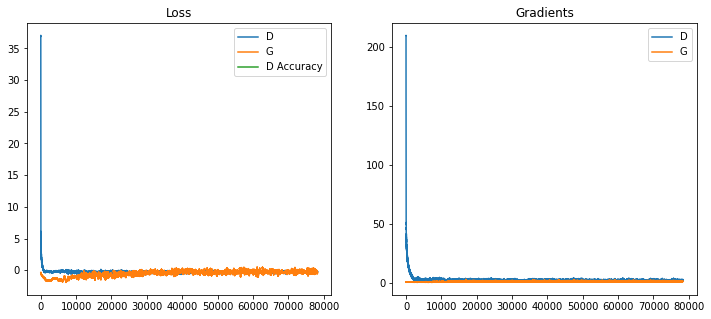

In [12]:
plot_loss_grads(unserialized_data['D Loss'], unserialized_data['D Accuracy'], unserialized_data['G Loss'], unserialized_data['D Grads'], unserialized_data['G Grads'] )             

In [0]:
with open('/content/drive/My Drive/ST449 Project/checkpoints/c-vanilla-3/model_lists2.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

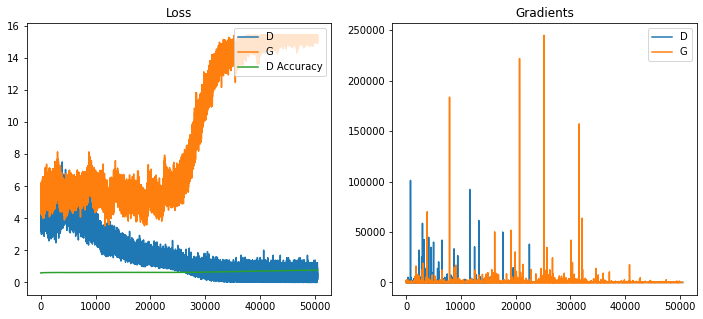

In [16]:
plot_loss_grads(unserialized_data['D Loss'], unserialized_data['D Accuracy'], unserialized_data['G Loss'], unserialized_data['D Grads'], unserialized_data['G Grads'] )             

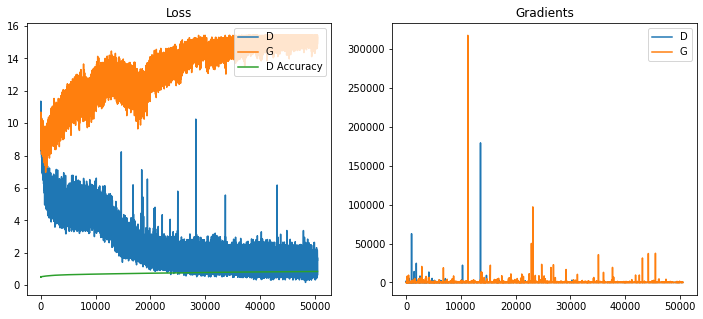

In [22]:
with open('/content/drive/My Drive/ST449 Project/checkpoints/vanilla-4/model_lists2.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
plot_loss_grads(unserialized_data['D Loss'], unserialized_data['D Accuracy'], unserialized_data['G Loss'], unserialized_data['D Grads'], unserialized_data['G Grads'] )   

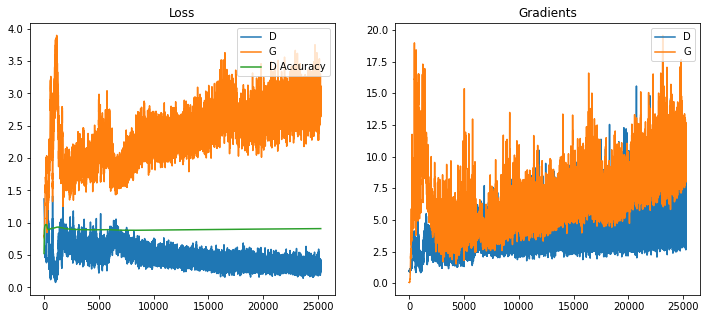

In [18]:
with open('/content/drive/My Drive/ST449 Project/checkpoints/vanilla-3/model_lists.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
plot_loss_grads(unserialized_data['D Loss'], unserialized_data['D Accuracy'], unserialized_data['G Loss'], unserialized_data['D Grads'], unserialized_data['G Grads'] )   